In [17]:
!pip install --upgrade torchio
!pip install torchio[plot]
!pip install unet

In [18]:
import torch
import torchio as tio
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from IPython import display
from tqdm.notebook import tqdm
import multiprocessing
import enum
import time
from unet import UNet

# 1: Dataset IXI


* Download a public dataset (IXI for example, https://brain-development.org/ixi-dataset/), a small subset is totally fine (T1 or T2);
* Use the "torchio" library to load the data


In [19]:
subjects=tio.datasets.IXI('path/to/ixi_root/',download=True,modalities=('T1', ),)

In [20]:
sample_subject = subjects[0]
print('Keys in subject sample:', tuple(sample_subject.keys()))  # ('T1',)
print('Shape of T1 data:', sample_subject['T1'][tio.DATA].shape)  # [1, 256, 256, 150]

Keys in subject sample: ('subject_id', 'T1')
Shape of T1 data: torch.Size([1, 256, 256, 150])


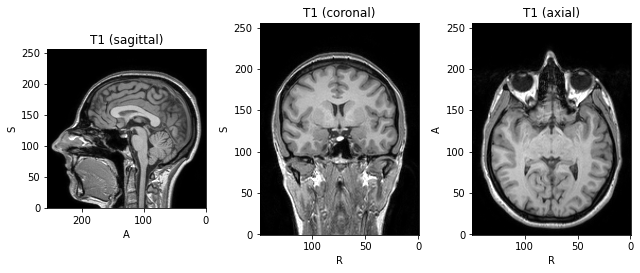

dict_keys(['subject_id', 'T1'])


In [21]:
sample_subject.plot(figsize=(9, 4))
print(sample_subject.keys())

# 2.Transforms

 Apply at least "ONE" degradation algorithm (noise, motion corruption, field inhomogeneities, etc), using torchio 





*   RandomMotion

In [22]:
transform = tio.Compose([tio.RandomNoise(std=0.5),#Add Gaussian noise with parameters.
    tio.RandomMotion(p=0.2), #Add random MRI motion artifact
])
 
images_dir = Path('path/to/ixi_root/T1')
image_paths = sorted(images_dir.glob('*.nii.gz'))
subjects_1 = []
for (image_path) in zip(image_paths):
    subject_1 = tio.Subject(
        mri=transform(tio.ScalarImage(image_path)),# Apply  artifacts...Train Network to remove this artifact.
        mri_original=tio.ScalarImage(image_path),# Keep the original image without artifact
    )
    subjects_1.append(subject_1)

In [23]:
training_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.CropOrPad((48, 60, 48)),     
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.OneHot(),
])

validation_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.CropOrPad((48, 60, 48)),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.OneHot(),
])

# 3.Training neural network

In [24]:
training_split_ratio = 0.9  # use 90% of samples for training, 10% for testing
num_subjects = len(subjects_1)
print(num_subjects)
num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects

num_split_subjects = num_training_subjects, num_validation_subjects
training_subjects, validation_subjects = torch.utils.data.random_split(subjects_1, num_split_subjects)


training_set = tio.SubjectsDataset(
    training_subjects, transform=training_transform)

validation_set = tio.SubjectsDataset(
    validation_subjects, transform=validation_transform)


581


In [25]:
print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

Training set: 522 subjects
Validation set: 59 subjects


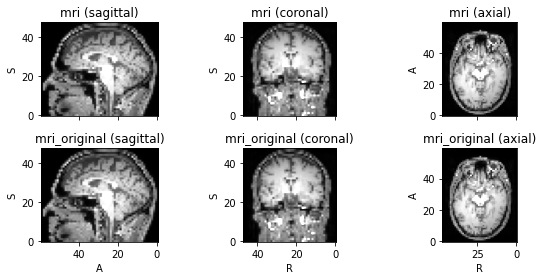

Compose([ToCanonical(), Resample(target=4, image_interpolation=linear, pre_affine_name=None, scalars_only=False), Pad(padding=(1, 1, 0, 0, 0, 0), padding_mode=0), Crop(cropping=(0, 0, 0, 0, 7, 6)), ZNormalization(masking_method=<function Transform.mean at 0x7f9fed2f0b90>), OneHot(num_classes=-1)])
Transformed Train


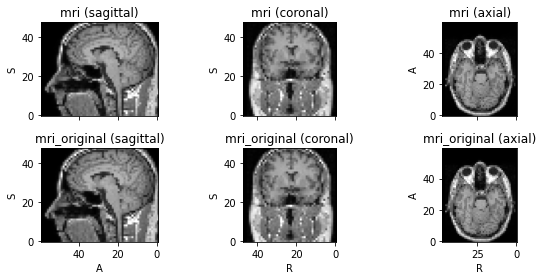

Compose([ToCanonical(), Resample(target=4, image_interpolation=linear, pre_affine_name=None, scalars_only=False), Pad(padding=(1, 1, 0, 0, 0, 0), padding_mode=0), Crop(cropping=(0, 0, 1, 0, 6, 6)), ZNormalization(masking_method=<function Transform.mean at 0x7f9fed2f0b90>), OneHot(num_classes=-1)])
Transformed Validate


In [26]:
training_instance = training_set[42]  # transform is applied inside SubjectsDataset
training_instance.plot(figsize=(9, 4))
reproduce_transform = training_instance.get_composed_history()
print(reproduce_transform)
print('Transformed Train')


validation_instance = validation_set[42]
validation_instance.plot(figsize=(9, 4))
reproduce_transform = validation_instance.get_composed_history()
print(reproduce_transform)
print('Transformed Validate')

In [27]:
num_workers = multiprocessing.cpu_count()
training_batch_size = 16
validation_batch_size = 2 * training_batch_size


training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=False,
    num_workers=num_workers,
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=validation_batch_size,
    num_workers=num_workers,
)

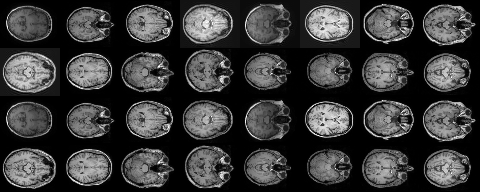

In [28]:
one_batch = next(iter(training_loader))
import torchvision
k = 24
batch_mri = one_batch['mri'][tio.DATA][..., k]
batch_real = one_batch['mri_original'][tio.DATA][..., k]
slices = torch.cat((batch_mri, batch_real))
image_path = 'batch_whole_images.png'
torchvision.utils.save_image(
    slices,
    image_path,
    nrow=training_batch_size//2,
    normalize=True,
    scale_each=True,
    padding=0,
)
display.Image(image_path)

In [30]:
#@title Deep Learning Model
import enum
import time
from unet import UNet

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4

class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

def prepare_batch(batch,device):
    inputs = batch['mri'][tio.DATA].to(device)
    inputs_o = batch['mri_original'][tio.DATA].to(device) 
    return inputs,inputs_o

def get_model_and_optimizer(device):
    model = UNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    return model, optimizer

def run_epoch(epoch_idx, action, loader, model, optimizer):
    is_training = action == Action.TRAIN
    epoch_losses = []
    times = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs,inputs_o = prepare_batch(batch,device)
        optimizer.zero_grad()        
        with torch.set_grad_enabled(is_training):
            outputs = model(inputs)                
            criterion=torch.nn.L1Loss(reduction='mean')
            batch_losses = criterion(outputs, inputs_o)
            batch_loss = batch_losses.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()
            times.append(time.time())
            epoch_losses.append(batch_loss.item())
    epoch_losses = np.array(epoch_losses)
    print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')
    return times, epoch_losses

def train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem):
    train_losses = []
    val_losses = []
    val_losses.append(run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer))
    for epoch_idx in range(1, num_epochs + 1):
        print('Starting epoch', epoch_idx)
        train_losses.append(run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer))
        val_losses.append(run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer))
        torch.save(model.state_dict(), f'{weights_stem}_epoch_{epoch_idx}.pth')
    return np.array(train_losses), np.array(val_losses)

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([32, 1, 48, 60, 48])) that is different to the input size (torch.Size([32, 2, 48, 60, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([27, 1, 48, 60, 48])) that is different to the input size (torch.Size([27, 2, 48, 60, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Validation mean loss: 2.070
Starting epoch 1


  0%|          | 0/33 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([16, 1, 48, 60, 48])) that is different to the input size (torch.Size([16, 2, 48, 60, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:97: UserWarning: Using a target size (torch.Size([10, 1, 48, 60, 48])) that is different to the input size (torch.Size([10, 2, 48, 60, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Training mean loss: 1.716


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 1.593
Starting epoch 2


  0%|          | 0/33 [00:00<?, ?it/s]

Training mean loss: 1.419


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 1.361
Starting epoch 3


  0%|          | 0/33 [00:00<?, ?it/s]

Training mean loss: 1.129


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 0.926
Starting epoch 4


  0%|          | 0/33 [00:00<?, ?it/s]

Training mean loss: 0.802


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 0.491
Starting epoch 5


  0%|          | 0/33 [00:00<?, ?it/s]

Training mean loss: 0.485


  0%|          | 0/2 [00:00<?, ?it/s]

Validation mean loss: 0.554


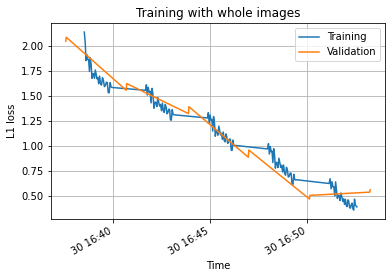

In [31]:
train_whole_images = True 
num_epochs = 5
model, optimizer = get_model_and_optimizer(device)
weights_path = 'whole_image_state_dict.pth'
if train_whole_images:
    weights_stem = 'whole_images'
    train_losses, val_losses = train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem)
    checkpoint = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'weights': model.state_dict(),
    }
    torch.save(checkpoint, weights_path)
else:
    weights_path = 'whole_image_state_dict.pth'
    weights_url = '/content/whole_images_epoch_5.pth' # To Do :: update url
    !curl --location --silent --output {weights_path} {weights_url}
    checkpoint = torch.load(weights_path)
    model.load_state_dict(checkpoint['weights'])
    train_losses, val_losses = checkpoint['train_losses'], checkpoint['val_losses']

def plot_times(axis, losses, label):
    from datetime import datetime
    times, losses = losses.transpose(1, 0, 2)
    times = [datetime.fromtimestamp(x) for x in times.flatten()]
    axis.plot(times, losses.flatten(), label=label)
    
fig, ax = plt.subplots()
plot_times(ax, train_losses, 'Training')
plot_times(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Time')
ax.set_ylabel('L1 loss')
ax.set_title('Training with whole images')
ax.legend()
fig.autofmt_xdate()

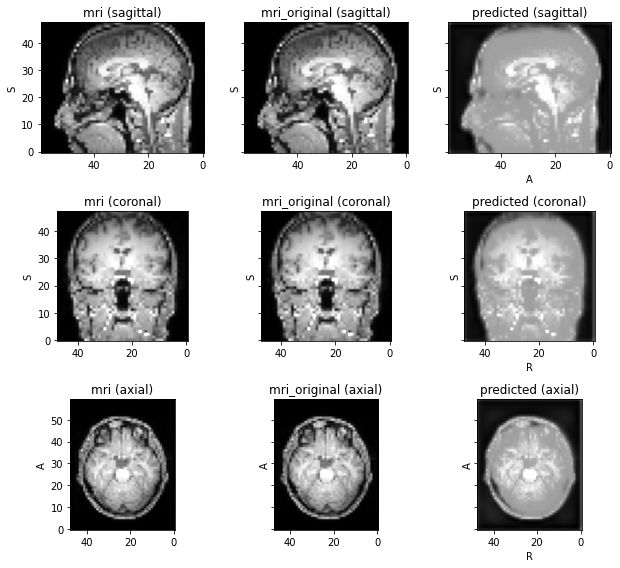

In [32]:
batch = next(iter(validation_loader))
model.eval()
inputs,inputs_o = prepare_batch(batch, device)
FIRST = 0
FOREGROUND = 1
with torch.no_grad():
    out_image = model(inputs).cpu()
affine = batch['mri'][tio.AFFINE][0].numpy()
affine_o = batch['mri_original'][tio.AFFINE][0].numpy()
subject = tio.Subject(
    mri=tio.ScalarImage(tensor=batch['mri'][tio.DATA][FIRST], affine=affine),
    mri_original=tio.ScalarImage(tensor=batch['mri_original'][tio.DATA][FIRST], affine=affine_o),
    predicted=tio.ScalarImage(tensor=out_image[FIRST], affine=affine_o),
)
subject.plot(figsize=(9, 8), cmap_dict={'predicted': 'gray'})